In [3]:
# !pip3 install tensorflow

In [4]:
# !pip3 install matplotlib

In [5]:
# !pip3 install pennylane

## Import the libraries

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math

In [7]:
# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU devices found")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Setting of the main hyper-parameters of the model

In [8]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
n_channels = 4 # Number of channels

SAVE_PATH = "../results/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


## Loading of the MNIST dataset

In [9]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quantum circuit as a convolution kernel

In [10]:
dev = qml.device("default.qubit", wires=n_channels)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_channels))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_channels)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

## Quantum Inspired  and Quantum convolution as Filters

In [11]:
def rotation_y(angle):
    cossine_angle = math.cos(np.pi*angle)
    sine_angle = math.sin(np.pi*angle)
    return(np.array([[cossine_angle, -sine_angle ],[ sine_angle ,cossine_angle]]))



def classic_filter(image):
    """Convolves the input image with by taking the trace of the rotation matrix applied for the image pixel"""
    out = np.zeros((14, 14, n_channels ))
    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a rotation matix and take the trace
            results = []
            for pixel in [image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0],image[j + 1, k + 1, 0]]:
                results.append(np.trace(rotation_y(pixel)))
                # results.append(np.linalg.det(rotation_y(pixel)))
                # results.append(pixel*np.linalg.det(rotation_y(pixel)))
                # results.append(pixel*np.trace(rotation_y(pixel)))
 
            # print(results)
            # out[j // 2, k // 2, 0] = np.sum(results)
            # # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_channels):
                out[j // 2, k // 2, c] = results[c]
                
    return out

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, n_channels))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Pre-processing of the dataset, applying the filter

Here we are investigating if the quantum filter add any advantace when compared to a quantum inspired filter

In [12]:
def apply_filter(image, type ):
    filtered_images = []
    print("fitlered pre-processing of images:")
    for idx, img in enumerate(image):
        print("{}/{}        ".format(idx + 1, np.shape(image)[0]), end="\r")
        if type == 0:
            filtered_images.append(classic_filter(img))
        elif type == 1:
            filtered_images.append(quanv(img))
    filtered_images = np.asarray(filtered_images)

    return(filtered_images)


 # apply the classical filter   

if PREPROCESS == True:
    filtered_train_images =  apply_filter(train_images, type=0)
    filtered_test_images = apply_filter(test_images, type=0)
# Save pre-processed images
    np.save(SAVE_PATH + "filtered_train_images.npy", filtered_train_images)
    np.save(SAVE_PATH + "filtered_test_images.npy", filtered_test_images)

 # apply the quantum filter   
    q_train_images = apply_filter(train_images, type=1)
    q_test_images = apply_filter(test_images, type=1)
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


fitlered pre-processing of images:
fitlered pre-processing of images:
fitlered pre-processing of images:
fitlered pre-processing of images:


In [13]:
# Load pre-processed images
filtered_train_images = np.load(SAVE_PATH + "filtered_train_images.npy")
filtered_test_images = np.load(SAVE_PATH + "filtered_test_images.npy")
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

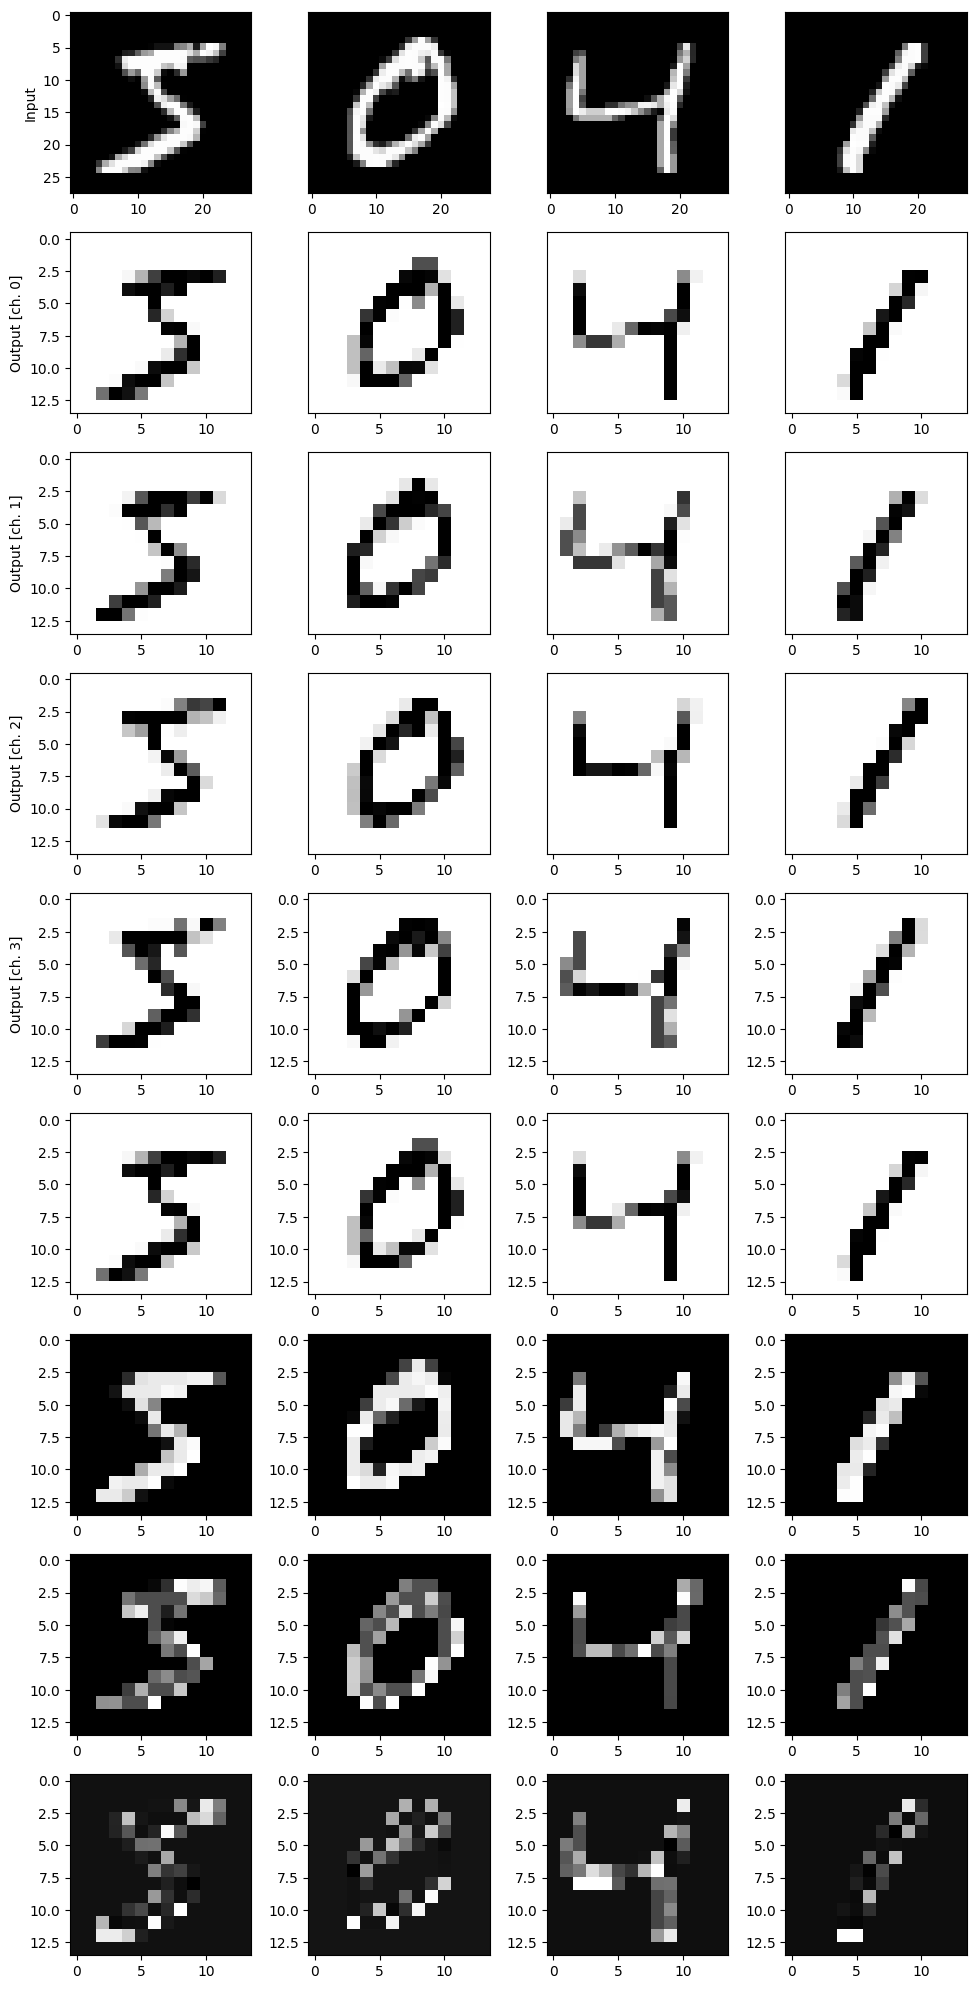

In [14]:
n_samples = 4

fig, axes = plt.subplots(1 + n_channels+4, n_samples, figsize=(10, 20))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")


    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(filtered_train_images[k, :, :, c], cmap="gray")
        axes[c + 5, k].imshow(q_train_images[k, :, :, c], cmap="gray")


plt.tight_layout()
plt.show()

## Define the Model

In [15]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training

In [16]:
classical_filtered_model = MyModel()

classical_filtered_history = classical_filtered_model.fit(
    filtered_train_images,
    train_labels,
    validation_data=(filtered_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


2024-05-06 14:21:38.501989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22125 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8a:00.0, compute capability: 8.6
I0000 00:00:1714969299.711946 1097995 service.cc:145] XLA service 0x7f79f4018eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714969299.712026 1097995 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-06 14:21:39.743747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 14:21:39.827530: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1714969300.420591 1097995 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the life

13/13 - 3s - 211ms/step - accuracy: 0.2200 - loss: 4.0619 - val_accuracy: 0.3333 - val_loss: 2.6204
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3400 - loss: 2.1392 - val_accuracy: 0.2000 - val_loss: 3.1388
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6800 - loss: 1.0848 - val_accuracy: 0.3333 - val_loss: 1.9057
Epoch 4/30
13/13 - 0s - 8ms/step - accuracy: 0.8000 - loss: 0.7304 - val_accuracy: 0.3333 - val_loss: 1.9797
Epoch 5/30
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.3816 - val_accuracy: 0.4000 - val_loss: 1.8277
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.2977 - val_accuracy: 0.5000 - val_loss: 1.7296
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.2028 - val_accuracy: 0.5667 - val_loss: 1.6363
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.1583 - val_accuracy: 0.6000 - val_loss: 1.6286
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.1258 - val_accuracy: 0.6333 - val_loss: 1.5882
Epoch 10/30
13/13 - 0s - 8ms

In [17]:
classical_model = MyModel()

classical_history = classical_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 168ms/step - accuracy: 0.1400 - loss: 2.3713 - val_accuracy: 0.1333 - val_loss: 2.1850
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.4600 - loss: 1.9534 - val_accuracy: 0.2667 - val_loss: 2.0125
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6400 - loss: 1.6614 - val_accuracy: 0.3333 - val_loss: 1.8622
Epoch 4/30
13/13 - 0s - 8ms/step - accuracy: 0.7600 - loss: 1.4217 - val_accuracy: 0.4333 - val_loss: 1.7320
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8800 - loss: 1.2229 - val_accuracy: 0.5667 - val_loss: 1.6222
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 1.0584 - val_accuracy: 0.6000 - val_loss: 1.5310
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.9221 - val_accuracy: 0.6000 - val_loss: 1.4555
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.8088 - val_accuracy: 0.6333 - val_loss: 1.3927
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.7139 - val_accuracy: 0.6333 - val_loss: 1.3401
Epoch 10/30
13

In [18]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 122ms/step - accuracy: 0.1000 - loss: 2.8906 - val_accuracy: 0.1333 - val_loss: 2.2739
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.3400 - loss: 1.9359 - val_accuracy: 0.2667 - val_loss: 2.1268
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6200 - loss: 1.6098 - val_accuracy: 0.4000 - val_loss: 1.9621
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7200 - loss: 1.3327 - val_accuracy: 0.5000 - val_loss: 1.7902
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8200 - loss: 1.0976 - val_accuracy: 0.5000 - val_loss: 1.6924
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 0.9178 - val_accuracy: 0.5000 - val_loss: 1.6126
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.7740 - val_accuracy: 0.5000 - val_loss: 1.5344
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 0.9800 - loss: 0.6591 - val_accuracy: 0.5333 - val_loss: 1.4721
Epoch 9/30
13/13 - 0s - 7ms/step - accuracy: 0.9800 - loss: 0.5657 - val_accuracy: 0.6000 - val_loss: 1.4224
Epoch 10/30
13/13

## Visualisation

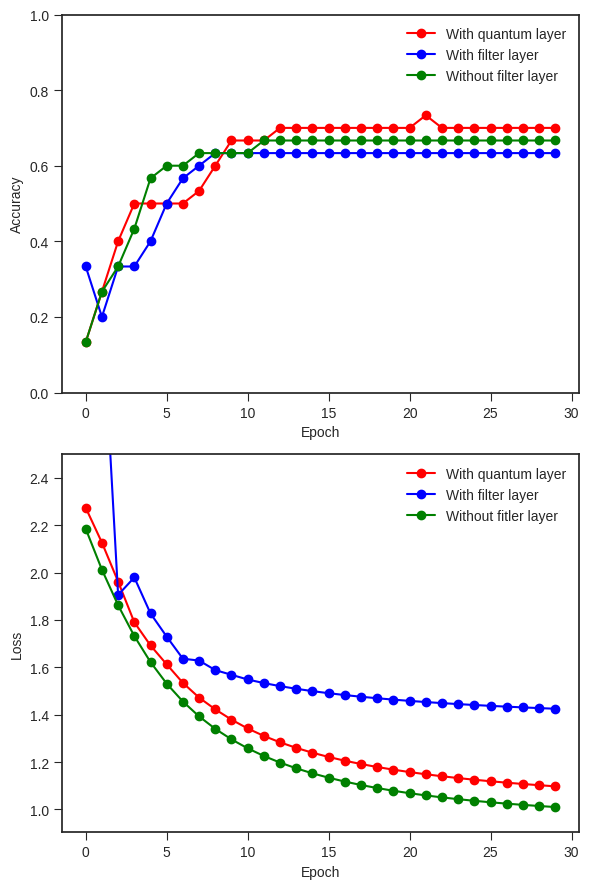

In [19]:
%matplotlib inline
plt.style.use("seaborn-v0_8-ticks")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-or", label="With quantum layer")
ax1.plot(classical_filtered_history.history["val_accuracy"], "-ob", label="With filter layer")
ax1.plot(classical_history.history["val_accuracy"], "-og", label="Without filter layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-or", label="With quantum layer")
ax2.plot(classical_filtered_history.history["val_loss"], "-ob", label="With filter layer")
ax2.plot(classical_history.history["val_loss"], "-og", label="Without fitler layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [20]:
np.shape(filtered_train_images)

(50, 14, 14, 4)

In [21]:
np.shape(train_images)

(50, 28, 28, 1)

In [22]:
np.shape(q_train_images)

(50, 14, 14, 4)

In [23]:
classical_filtered_history.history["val_accuracy"][-1]

0.6333333253860474